# DoWhy

## Intro

### Simple start

#### Four steps of causal inference

1. Model a causal problem

DoWhy creates an underlying causal graphical model
for each problem.
You may provide a partial graph,
DoWhy will assume rest of variables
are partial confounders.

2. Identify a target estimand

Based on the causal graph,
DoWhy finds all possible ways
of identifying a desired causal effect
based on the graphical model.

3. Estimate causal effect based on the identified estimand

Dowhy supports methods
based on both back-door criterion
and instrumental variables.
It also provides
a non-parametric permutation test
for testing the statistical significance of obtained estimates.

  - Methods based on estimating the treatment assignment
    1. Propensity-based stratification
    2. Propensity score matching
    3. Inverse propensity weighting
  - Methods based on estimating the response surface
    1. Regression

4. Refute the obtained estimate

Having access to multiple refutation methods
to verify a causal inference
is the key benefit of DoWhy.

Refutation methods are:

  1. Placebo treatment
  2. Irrelevant additional confounder
  3. Subset validation

### DoWhy API

In [64]:
import logging

import dowhy
import dowhy.datasets
import dowhy.plotter
import numpy as np

In [80]:
# Make data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_effect_modifiers=1,
    num_samples=10000,
    treatment_is_binary=True,
)
df = data["df"]
df.head()

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,-0.291136,1.0,0.405625,-1.084409,0.658474,2.346478,-1.290980,1.113309,True,17.579280
1,-1.869697,1.0,0.836053,-1.772811,-0.010525,0.892431,-0.194604,1.159604,True,11.836222
2,0.574219,0.0,0.578126,-2.101330,1.108997,-0.796930,-1.288588,1.881431,True,2.556918
3,-0.719803,1.0,0.263592,-1.068353,1.158350,1.154412,-1.493280,1.410720,True,12.796653
4,-0.760350,1.0,0.074408,0.249099,0.989176,-0.995689,-1.041891,0.325029,True,4.123238


In [14]:
# Causal graph
data["gml_graph"]

'graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[source "Unobserved Confounders" target "v0"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]node[ id "X0" label "X0"] edge[ source "X0" target "y"]]'

In [21]:
for column in ("treatment_name", "outcome_name"):
    print(f"{column}:\t{data[column]}")

treatment_name:	['v0']
outcome_name:	y


INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


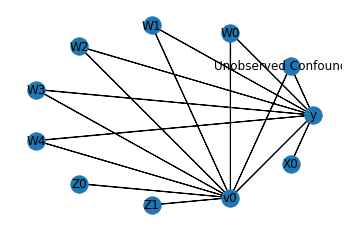

In [81]:
# Model
model = dowhy.CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"],
)
model.view_model()

In [82]:
# Identify estimand
# This does not depend on the data
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W0', 'W4', 'W1', 'Unobserved Confounders', 'W3', 'W2']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



**Backdoor path criterion**
A method of conditioning
where you find the least amount of variables to condition on
that would result in the blocking of all paths
that pass through both the treatment and outcome variables.

**Instrumental variables (IV)**
are variables that can be leveraged
to create natural experiments.

In [83]:
# Estimate the causal effect
# This uses data
causal_estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_stratification"
)
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W4+W1+W3+W2


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W0+W4+W1+W3+W2
## Estimate
Value: 10.002621850103454

Causal Estimate is 10.002621850103454


/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now refute.
A **common cause variable**
is on that points
to both the treatment
and the outcome variable
in the causal graph.

In [28]:
# Add random common cause variable
res_random = model.refute_estimate(
    identified_estimand, causal_estimate, method_name="random_common_cause"
)
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W4+W1+W3+W2+w_random


Refute: Add a Random Common Cause
Estimated effect:(10.607681319438232,)
New effect:(10.616117223613308,)



/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
# Add unobserved common cause variable
res_unobserved = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.01,
    effect_strength_on_outcome=0.02,
)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W4+W1+W3+W2


Refute: Add an Unobserved Common Cause
Estimated effect:(10.607681319438232,)
New effect:(9.852003752521128,)



/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For random placebo variable,
we should expect causal effect
to ideally be zero.

In [32]:
# Replacement treatment with random (placebo) variable
res_placebo = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
)
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+W4+W1+W3+W2


Refute: Use a Placebo Treatment
Estimated effect:(10.607681319438232,)
New effect:(-0.06338538501242091,)



/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
# Remove a random subset of data
res_subset = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.9,
    random_seed=42,
)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W4+W1+W3+W2
/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a subset of data
Estimated effect:(10.607681319438232,)
New effect:(10.607003246209247,)



## Example: Finding causal effects from observed data

Determine whether
the treatment causes the outcome,
or the correlation is due to another cause.

### Data

In [49]:
# Create data
rvar = 1 if np.random.uniform() > 0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar, sd_error=0.2)
df = data_dict["df"]
for column in ("treatment_name", "outcome_name", "time_val"):
    print(f"{column}:\t{data_dict[column]}")
df.head()

treatment_name:	Treatment
outcome_name:	Outcome
time_val:	s


,Treatment,Outcome,w0,s
0,9.680688,19.502170,3.956999,2.792633
1,7.732760,15.391219,1.747609,1.499203
2,10.155890,20.364040,3.959390,3.201518
3,5.797057,11.408715,-0.350736,5.089695
4,3.705391,7.555640,-2.240245,5.673442


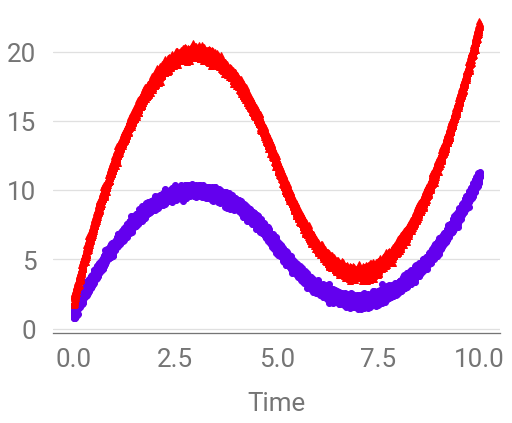

In [44]:
dowhy.plotter.plot_treatment_outcome(
    df[data_dict["treatment_name"]],
    df[data_dict["outcome_name"]],
    df[data_dict["time_val"]],
)

### Step 1: Model problem as causal graph

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Treatment'] on outcome ['Outcome']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


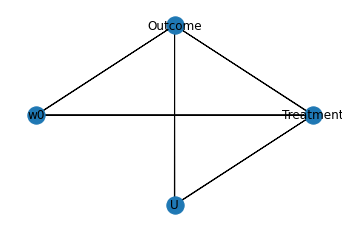

In [51]:
model = dowhy.CausalModel(
    data=df.drop(columns=[""]),
    treatment=data_dict["treatment_name"],
    outcome=data_dict["outcome_name"],
    common_causes=data_dict["common_causes_names"],
    instruments=data_dict["instrument_names"],
)
model.view_model(layout="dot")

### Step 2: Identify causal effect using properties of graph

In [53]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'w0']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(Expectation(Outcome|w0))
d[Treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)
### Estimand : 2
Estimand name: iv
No such variable found!



### Step 3: Estimate causal effect

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


Causal Estimate is 1.002029622744427


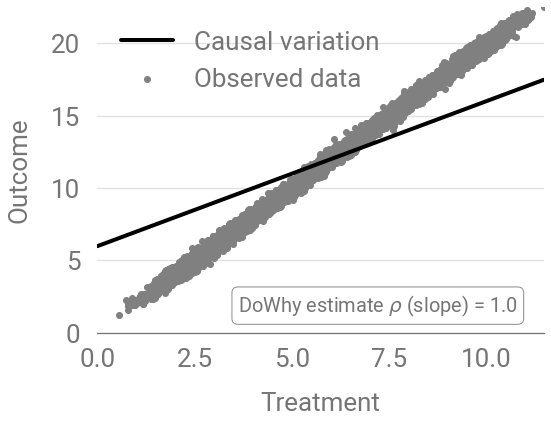

In [54]:
estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.linear_regression"
)
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(
    estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]]
)

In [57]:
# Check if estimate is correct
print("DoWhy estimate is " + str(estimate.value))
print("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is 1.002029622744427
Actual true causal effect was 1


### Step 4: Refute the estimate

In [58]:
# Add a random common cause variable
res_random = model.refute_estimate(
    identified_estimand, estimate, method_name="random_common_cause"
)
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0+w_random


Refute: Add a Random Common Cause
Estimated effect:(1.002029622744427,)
New effect:(1.0015036028592421,)



In [59]:
# Replace treatment with random placebo variable
res_placebo = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
)
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


Refute: Use a Placebo Treatment
Estimated effect:(1.002029622744427,)
New effect:(-0.0018050006491243664,)



In [60]:
# Remove a random subset of the data
res_subset = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.9,
)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


Refute: Use a subset of data
Estimated effect:(1.002029622744427,)
New effect:(1.0053539844928423,)



## Different estimation methods for causal inference

### Data

In [132]:
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_treatments=1,
    num_samples=10000,
    treatment_is_binary=True,
    outcome_is_binary=False,
)
df = data["df"]
df.head()

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.126631,0.676719,-1.193620,0.965344,0.395817,0.195735,True,9.398495
1,1.0,0.977282,-0.124809,-0.029385,0.493209,-0.288349,-0.123539,True,10.282511
2,0.0,0.475268,0.697311,-0.399198,-0.875399,-2.439431,-0.940355,False,-3.913667
3,0.0,0.528922,-0.150050,0.558933,-0.625935,-0.902617,-0.022760,True,9.682558
4,1.0,0.182928,0.950376,-0.724418,-0.918854,-1.344832,-0.170977,True,6.589575


### Identify the causal estimand

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


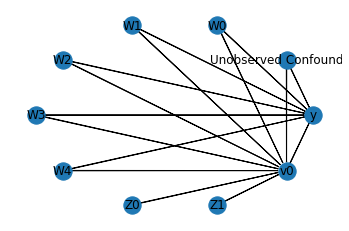

In [133]:
# With graph
model = dowhy.CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"],
    instruments=data["instrument_names"],
    logging_level=logging.INFO,
)
model.view_model()

In [134]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W0', 'W4', 'W1', 'W3', 'Unobserved Confounders', 'W2']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



### Linear regression

Fit a linear regression model
to the treatment and identified confounders variables.
The coefficient of the treatment variable
is extracted as the treatment effect.

In [125]:
causal_estimate_reg = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W4+W1+W3+W2


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W0+W4+W1+W3+W2
## Estimate
Value: 9.999999999999998

## Statistical Significance
p-value: <0.001

Causal Estimate is 9.999999999999998


### Stratification

Stratify users into bins
based on identified confounders.

In [126]:
causal_estimate_strat = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units="att",
)
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W4+W1+W3+W2


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W0+W4+W1+W3+W2
## Estimate
Value: 9.965105534951613

Causal Estimate is 9.965105534951613


/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Propensity matching

Model a user's likelihood
to receive the treatment.
Match individual users with equal propensity scores
and compare treatment effect.

In [127]:
causal_estimate_match = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="atc",
)
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W4+W1+W3+W2
/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W0+W4+W1+W3+W2
## Estimate
Value: 10.188662615492813

Causal Estimate is 10.188662615492813


### Weighting

Use inverse propensity score
to assign weights to units in data.
Find difference in weighed sum
between treated and untreated populations.

In [128]:
causal_estimate_ipw = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units="ate",
    method_params={"weighting_scheme": "ips_weight"},
)
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W4+W1+W3+W2


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W0+W4+W1+W3+W2
## Estimate
Value: 10.631063140205459

Causal Estimate is 10.631063140205459


/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/paulo/Library/Caches/pypoetry/virtualenvs/causal-modeling-_sR9oWRO-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Instrumental variable

Use instrumental variable method
to compute effect of treatment.
Specify which instrumental variable to use with `method_params`.
Look for variations in instrumental variable
due to external effects.
Like the treatment being on the Oprah Winfrey show,
or featured on the front of the app page.
Treat difference in effect as causal estimate.

In [129]:
causal_estimate_iv = model.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable",
    method_params={"iv_instrument_name": "Z0"},
)
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same way by common causes of ['v0'] and y



*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z

### Regression discontinuity

Compare uses
due to arbitrary changes in treatment.
Example is finding how effective
an app store recommender is.
The recommendation system
will typically show user top 3 highest rated recommendations.
Can compare performance of /#3 to /#4—
which is not shown to the user,
but is similarly scored to /#3.

In [137]:
causal_estimate_regdist = model.estimate_effect(
    identified_estimand,
    method_name="iv.regression_discontinuity",
    method_params={
        "rd_variable_name": "Z1",
        "rd_threshold_value": 0.5,
        "rd_bandwidth": 0.1,
    },
)
print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

INFO:dowhy.causal_estimator:Using Regression Discontinuity Estimator
INFO:dowhy.causal_estimator:
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(y, local_rd_variable))⋅Expectation(Derivative(v0, local

              -1
_rd_variable))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['local_treatment'] is affected in the same way by common causes of ['local_treatment'] and local_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome local_outcome is affected in the same way by common causes of ['local_treatment'] and local_outcome



      local_rd_variable  local_treatment  local_outcome
2              0.475268            False      -3.913667
3              0.528922             True       9.682558
7              0.440315             True       7.851732
17             0.425173             True      15.433593
18             0.490777             True       8.483642
...                 ...              ...            ...
9976           0.460261             True       7.947753
9978           0.585771            False      -3.628647
9980           0.523225             True      10.395942
9995           0.447534             True       9.916126
9998           0.584175             True      11.484253

[1947 rows x 3 columns]
*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W1,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} an